**Objectif** : on va dans un premier temps chercher à prédire la consommation électrique uniquement à partir des données historiques. Pour cela on va tronquer la fin de la série, effectuer une prédiction puis vérifier avec les données réelles. Dans un deuxième temps on va utiliser les données météorologiques afin d'améliorer la prédiction.

# 1 - Import des bibliothèques

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [24]:
chemin_scripts = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(chemin_scripts)

from fonctions_conso import importation, clean, traitement_valeurs_manquantes

# 2 - Récupération des données

In [25]:
url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/csv?lang=fr&refine=libelle_metropole%3A%22M%C3%A9tropole%20du%20Grand%20Paris%22&facet=facet(name%3D%22libelle_metropole%22%2C%20disjunctive%3Dtrue)&timezone=Europe%2FParis&use_labels=true&delimiter=%3B"
df = traitement_valeurs_manquantes(clean(importation(url)))[['conso_final']]

C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\scripts\fonctions_conso.py:11: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(url, sep=';')


In [21]:
df.head(2)

,conso_final
date_heure,
2020-01-01 01:00:00,5090.0
2020-01-01 01:15:00,5018.0


# 3 - Test de stationnarité

Tester la stationnarité d'une série temporelle est crucial pour l'analyse et la modélisation des données temporelles. La stationnarité garantit la stabilité des propriétés statistiques de la série au fil du temps, permettant d'appliquer des modèles appropriés et d'obtenir des résultats valides et des prévisions fiables.

On rappelle qu'une série temporelle à valeurs réelles en temps discret $X_1,...,X_t$ est dite faiblement stationnaire si :

$$
\begin{cases}
\mathbb{E}[X_i] = \mu \hspace{1cm} \forall i \\
Var(X_i) = \sigma ^2 \hspace{1cm} \forall i \\
Cov(X_i, X_{i-k}) = \rho _k \hspace{1cm} \forall i, \forall k
\end{cases}
$$

On va commencer par tester la stationnarité de la série des consommations d'électricité de la métropole parisienne afin de choisir par la suite le bon modèle de prédiction. Pour cela, on effectue le test de racine unitaire de Dickey-Füller augmenté (test ADF) dont les hypothèses sont les suivantes :

$$
\begin{cases}
H_0 : \text{présence de racine unitaire} \Leftrightarrow \text{série non stationnaire} \\
H_1 : \text{absence de racine unitaire} \Leftrightarrow \text{série stationnaire}
\end{cases}
$$

Les valeurs critiques du test ADF diffèrent selon l'hypothèse choisie pour le processus générateur de données (DGP) de la série temporelle :

- **DGP 1** (sans partie déterministe, option `regression='n'` dans adfuller) : 
$ X_t = \phi X_{t-1} + \epsilon_t $

Valeur critique au seuil 5% pour le rejet de $H_0$ : -1,95

- **DGP 2** (avec constante, option `regression='c'` dans adfuller) :  
$ X_t = a + \phi X_{t-1} + \epsilon_t $ 

Valeur critique au seuil 5% pour le rejet de $H_0$ : -2,89

- **DGP 3** (avec constante et trend, option `regression='ct'` dans adfuller) : 
$X_t = a + b t + \phi X_{t-1} + \epsilon_t $ 

Valeur critique au seuil 5% pour le rejet de $H_0$ : -3,45

Lorsque la valeur du test ADF est inférieure au seuil critique associé à l'hypothèse choisie, on rejette $H_0$, c’est-à-dire que la série est stationnaire.


In [17]:
def adf_table(series, alpha=0.05):
    results = []
    dgp = {'n' : 'DGP1', 'c' : 'DGP2', 'ct' : 'DGP3'}

    for reg, label in dgp.items():
        adf_result = adfuller(series, regression=reg)

        adf_stat = adf_result[0]
        crit_value = adf_result[4]['5%']

        conclusion = "Stationnaire" if adf_stat < crit_value else "Non stationnaire"

        results.append({
            "DGP": label,
            "ADF statistic": adf_stat,
            "Valeur critique (5%)": crit_value,
            "Conclusion": conclusion
        })

    return pd.DataFrame(results)

In [37]:
df_adf = adf_table(df)

In [38]:
df_adf

,DGP,ADF statistic,Valeur critique (5%),Conclusion
0,DGP1,-1.273610,-1.941001,Non stationnaire
1,DGP2,-5.760323,-2.861554,Stationnaire
2,DGP3,-5.762672,-3.410511,Stationnaire


**Conclusion** : la série est stationnaire autour d'une constante $\neq$ 0. Elle est de type DGP3 avec a et b significatifs. On n'a donc pas besoin de la stationnariser et il va être plus facile d'effectuer des prédictions.

# 4 - Dé-saisonnalisation

Il existe plusieurs modèles classiques pour la modélisation des séries temporelles :
- <u>AR</u> (AutoRegressive) : la valeur actuelle dépend de ses valeurs passées, utilisé lorsque la série présente de l'autocorrélation
- <u>MA</u> (MovingAverage) : la valeur actuelle dépend des erreurs passées, utilisé lorsque les chocs passés influencent les valeurs futures
- <u>ARMA</u> : AR + MA utilisé lorsque les séries sont stationnaires
- <u>ARIMA</u> : extension d'ARMA aux séries non stationnaires basé sur un nombre de différenciations qui rend la série stationnaire
- <u>SARIMA</u> : ARIMA + saisonnalité
- <u>GARCH</u> : modélise la volatilité passée combinée à l'effet des chocs passés

Chaque modèle dépend d'un ou plusieurs paramètres appelés *ordre* à déterminer à partir des valeurs de la série.

La série étant stationnaire, on va vraisemblablement l'estimer par un modèle **ARMA**. Mais la série des consommations électriques présente de fortes saisonnalités journalière, hebdomadaire et mensuelle ce qui risque de biaiser fortement les coefficients de l'ARMA. Pour cela on va devoir au préalable **désaisonnaliser** la série. On ne va pas pouvoir utiliser un modèle SARIMA car le modèle SARIMA ne peut gérer qu'une seule saisonnalité.

## 4.1 - STL

On va utiliser **STL** (Seasonal–Trend decomposition using LOESS) pour gérer la saisonnalité. Cette méthode va permettre d'isoler les saisonnalités (jour, semaine, mois),  de comprendre la structure de la série et donc de la rendre exploitable pour des modèles comme ARMA. Pour cela, STL décompose la série temporelle en 3 parties :
$$ X_t = T_t + S_t + \epsilon _t$$
où : 
- $X_t$ est la série temporelle observée 
- $T_t$ correspond à la tendance de la série, elle capture la composante à long terme montrant la direction générale de la série. 
- $S_t$ est la composante saisonnière, elle représente les variations régulières et périodiques liées à des motifs récurrents. On va ici considérer 3 saisonnalités : jour, semaine et mois donc cette composante est elle même composée de 3 composantes disctinctes.
- $\epsilon _t$ est la composante résiduelle, on a $\epsilon _t = C_t + u_t$ avec $C_t$ la composante cyclique qui capture des variations à plus long terme que la composante saisonnière mais sans une périodicité fixe et $u_t$ un bruit blanc purement aléatoire. La décomposition de la composante résiduelle entre $C_t$ et $u_t$ se fera en appliquant un ARMA à la décomposition STL.

**Pb** : on a un échantillon beaucoup trop gros, le code prendrait beaucoup trop de temps à s'exécuter. On va être obligés de réduire la fréquence des observations à 1 heure au lieu de 15 minutes. Ainsi, la décomposition journalière et hebdomaire se font assez rapidement, la décomposoition mensuelle prend quant à elle $\approx$ 20 minutes.

In [26]:
df_red = df[(df.index.minute == 0) & (df.index.second == 0)]
df_red.shape[0]

52511

Le dataframe ainsi réduit ne comporte plus que $\approx$ 50 00 observations contre plus de 210 000 pour le dataframe initial

In [27]:
#extraire la saison journalière (24 mesures par jour)

stl_daily = STL(df_red, period=24, robust=True)
res_daily = stl_daily.fit()
deseason_daily = df_red['conso_final'] - res_daily.seasonal

In [28]:
#extraire la saison hebdomadaire sur les résidus (24*7=168 mesures)

stl_weekly = STL(deseason_daily, period=168, robust=True)
res_weekly = stl_weekly.fit()
deseason_weekly = deseason_daily - res_weekly.seasonal

In [29]:
#extraire la saison mensuelle sur les résidus (24*30=720 mesures)

stl_monthly = STL(deseason_weekly, period=720, robust=True)
res_monthly = stl_monthly.fit()
residuals = deseason_weekly - res_monthly.seasonal

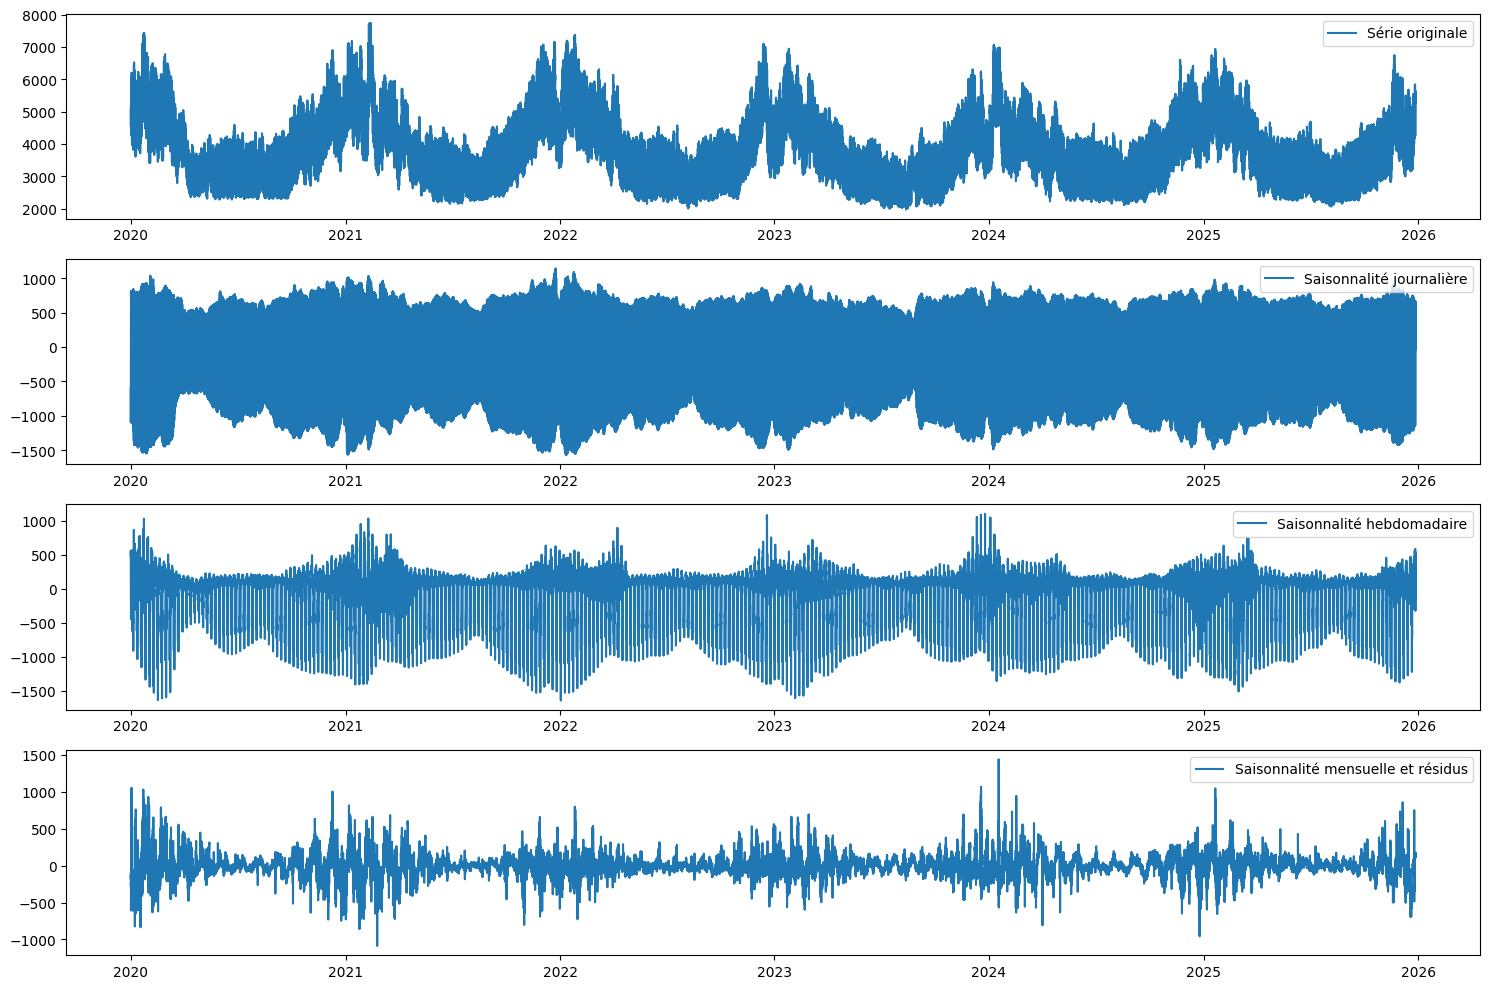

In [10]:
#visualiser

plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
plt.plot(df_red, label='Série originale')
plt.legend()

plt.subplot(4,1,2)
plt.plot(res_daily.seasonal, label='Saisonnalité journalière')
plt.legend()

plt.subplot(4,1,3)
plt.plot(res_weekly.seasonal, label='Saisonnalité hebdomadaire')
plt.legend()

plt.subplot(4,1,4)
plt.plot(res_monthly.seasonal, label='Saisonnalité mensuelle et résidus')
plt.legend()

plt.tight_layout()
plt.show()

**Interprétation**

## 4.2 - Récupération de la composante résiduelle

Les STL ont permis d'enlever les saisonnalités, on se retrouve donc avec la tendance et la composante résiduelle, c'est-à-dire $ T_t + \epsilon _t$. On veut appliquer un modèle ARMA sur les résidus $\epsilon _t$ seuls donc on soustrait la tendance aux résultats obtenus (ce qui permet au passage de les stationnariser autour de 0) :

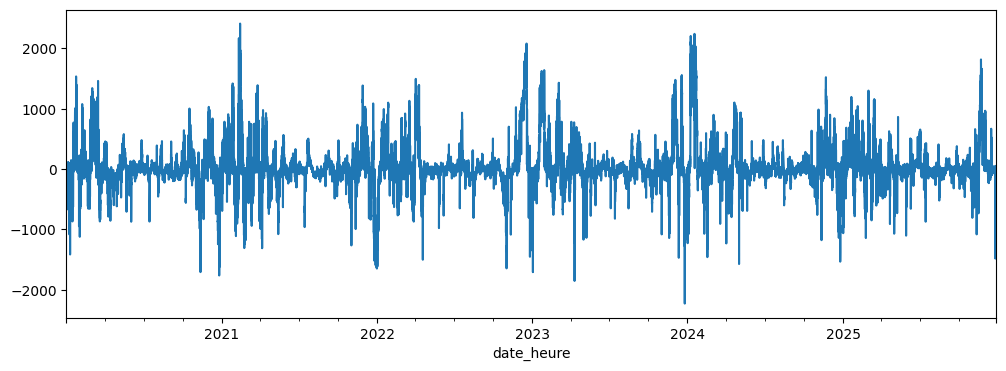

In [21]:
residuals_stationary = residuals - res_monthly.trend
residuals_stationary.plot(figsize=(12,4));

On va vérifier la stationnarité de la composante résiduelle avec un test ADF comme précédemment :

In [22]:
df_adf_res = adf_table(residuals_stationary)
df_adf_res

,DGP,ADF statistic,Valeur critique (5%),Conclusion
0,DGP1,-12.496674,-1.941005,Stationnaire
1,DGP2,-12.589207,-2.861595,Stationnaire
2,DGP3,-12.605508,-3.410574,Stationnaire


La composante résiduelle est très clairement stationnaire, on va pouvoir passer à la modélisation par un ARMA.

# 5 - Modèle ARMA sur les résidus obtenus 

Un modèle ARMA est défini par 2 ordres : 
- **p** l'ordre de l'AR qui spécifie le nombre de termes autorégressifs à inclure dans le modèle. Il indique combien de valeurs passées sont utilisées pour prédire la valeur actuelle.
- **q** l'ordre du MA qui spécifie le nombre de termes de la moyenne mobile à inclure dans le modèle. Il indique combien de résidus passés sont utilisés pour prédire l'observation actuelle.

On va devoir déterminer ces ordres. Pour cela on dispose de plusieurs méthodes :
- visuellement en regardant l'ACF et le PACF
- en calculant les critères d'information AIC et BIC

On va ensuite confirmer la validité des paramètres choisis en vérifiant la blancheur des résidus du modèle ainsi estimé.

## 5.1 - Détermination des paramètres

### 5.1.1 - ACF et PACF

L'**ACF** (Autocorrelation Function) mesure la corrélation entre les valeurs d’une série temporelle et leurs valeurs décalées dans le temps appelées lags. La **PACF** (Partial Autocorrelation Function) mesure la corrélation entre une valeur et son lag, en éliminant l’influence des lags intermédiaires.

On utilise l'ACF et la PACF pour identifier si la série temporelle correspond plutôt à un modèle AR, MA ou ARMA et pour identifier les ordres p et q associés :

- modèle AR(p) : l'ACF décroît progressivement et la PACF chute brusquement après le lag p
- modèle MA(q) : la PACF décroît progressivement et l'ACF chute brusquement après le lag q
- modèle ARMA(p,q) : l'ACF et la PACF présente une décroissance plus complexe sans chute brutale

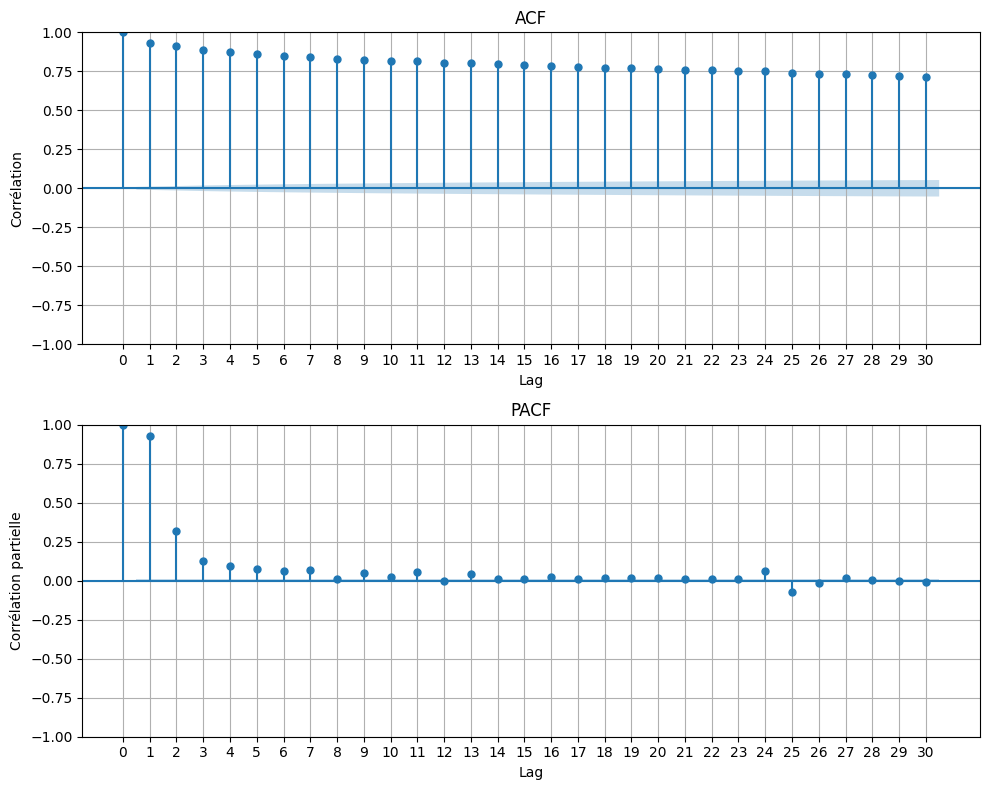

In [23]:
#subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

#ACF
plot_acf(residuals_stationary, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)
ax1.set_xticks(np.arange(0, 31, 1))

#PACF
plot_pacf(residuals_stationary, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)
ax2.set_xticks(np.arange(0, 31, 1))

#afficher
plt.tight_layout()
plt.show()

**Interprétation** :
- pas de coupure nette de l'ACF, donc il ne semble pas y avoir de partie MA $\implies$ q=0
- coupure nette de la PACF après le lag 2, semble suggérer un AR pur de lag 2 $\implies$ p=2
  
L'analyse de l'ACF et de la PACF semblerait nous suggérer d'utiliser un AR(2). On va estimer ce modèle et tester la blancheur des résidus obtenus par un test de Ljung-Box. Si ceux-ci ne sont pas blancs c'est que le modèle n'a pas capturé toute la structure du signal et n'est donc pas adapté à la série.

In [30]:
#AR2
ar2_model = ARIMA(residuals_stationary, order=(2,0,0))
ar2_fit = ar2_model.fit()

#test de Ljung-Box
ljung_box = acorr_ljungbox(resid_ar2, lags=[10,20,30], return_df=True)
print("Test Ljung-Box sur les résidus pour un AR(2) :")
print(ljung_box)

C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Test Ljung-Box sur les résidus pour un AR(2) :
        lb_stat      lb_pvalue
10  1291.150639  3.107939e-271
20  1476.125446  5.270230e-301
30  2228.570849   0.000000e+00


**Pb** : résidus non blancs, modèle abandonné. Cela est sans doute du au grand nombre d'observations ce qui peut modifier les seuils de significativité standards et rendre l'ACF et la PACF plus difficile à interpréter visuellement.

### 5.1.2 - Critères d'information

On compare différents modèles ARMA et on calcule le BIC pour chaque combinaison de p et q. On retient le modèle qui minimise le BIC.

In [27]:
model = pm.auto_arima(
    residuals_stationary,
    start_p=0, max_p=5,  #on teste les combinaisons de p et q entre 0 et 5
    start_q=0, max_q=5,
    d=0,                 #la série est déjà stationnaire
    seasonal=False,
    stepwise=True,
    information_criterion='bic',
    suppress_warnings=True)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                52511
Model:               SARIMAX(4, 0, 2)   Log Likelihood             -323077.677
Date:                Sun, 28 Dec 2025   AIC                         646169.354
Time:                        11:36:34   BIC                         646231.436
Sample:                    01-01-2020   HQIC                        646188.757
                         - 12-27-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5412      0.018     30.807      0.000       0.507       0.576
ar.L2          0.9621      0.024     40.818      0.000       0.916       1.008
ar.L3         -0.3650      0.006    -61.518      0.0

**Interprétation** : la détermination du modèle par le BIC nous renvoie un ARMA(4,2). La p-value associée au test de Ljung-Box de blancheur des résidus est de 0.88 > 0.5 donc les résidus sont bien blancs c'est-à-dire qu'il ne reste pas de structure dans les données qui ne soit pas décrite par le modèle.

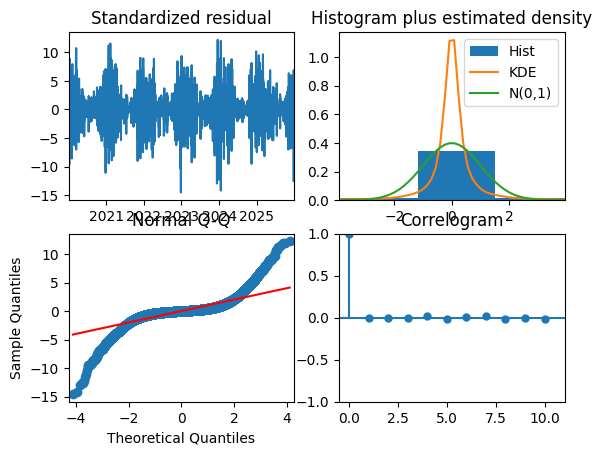

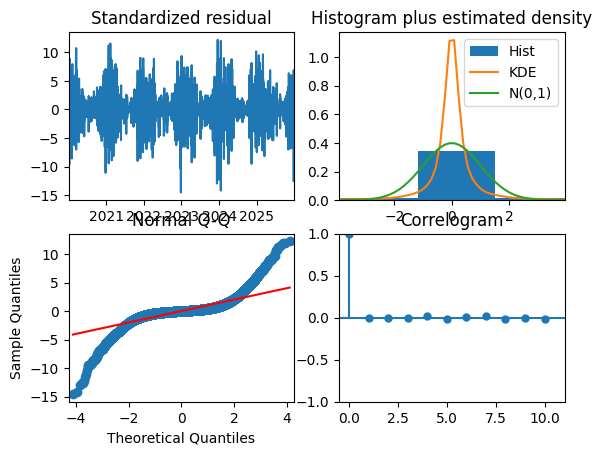

In [31]:
model.plot_diagnostics()

## 5.2 - Estimation du modèle

On va donc choisir un ARMA(4,2) pour modéliser nos données **dé-saisonnalisées** et **dé-trendées**. Il faut bien faire attention au fait que l'ARMA ne modélise ici que la composante résiduelle de la série temporelle initiale puisque l'on a désaisonnalisé la série et qu'on en a retiré la tendance.

On rappelle que pour $X_t$ la série des consommations de la métropole parisienne on a

$$X_t = T_t + S_t + \epsilon _t$$

avec $\epsilon _t \sim ARMA(4,2)$ que l'on a appelé `residual_stationnary`

L'ARMA(4,2) prédit donc $\hat{\epsilon_t}$ et non $X_t$ directement. Une fois $\hat{\epsilon_t}$ obtenu, il faut y rajouter la saisonnalité déterminée précedemment ainsi que la tendance.



L'objectif va être d'entrainer le modèle sur une partie des données (ensemble de **train**) puis de prédire l'autre partie des données (ensemble de **test**). Une fois la composante résiduelle prédite on lui ajoute les saisonnalités et la trend pour obtenir la vraie prédiction pour notre série. Finalement on évalue la qualité de la prédiction obtenue via différentes métriques.

On définit l'ensemble de test comme les 4 derniers mois dont on dispose (1 mois $\approx$ 720 mesures $\implies$ 4 mois $\approx$ 2 880 mesures).

In [3]:
#pour ne pas tout relancer
#residuals_stationary = pd.read_csv("residuals_stationary.csv", index_col=0, parse_dates=True).iloc[:, 0]

In [40]:
#séparation train-test

n_test = 4 * 720   #4 mois 
train_resid = residuals_stationary.iloc[:-n_test]
test_resid  = residuals_stationary.iloc[-n_test:]
test_data = df_red['conso_final'].iloc[-n_test:]

In [19]:
#entrainer le modèle

arma_model = ARIMA(train_resid, order=(4, 0, 2), trend='n')
arma_fit = arma_model.fit()

C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

In [20]:
arma_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      0   No. Observations:                49631
Model:                 ARIMA(4, 0, 2)   Log Likelihood             -305961.469
Date:                Sun, 28 Dec 2025   AIC                         611936.938
Time:                        18:16:02   BIC                         611998.624
Sample:                    01-01-2020   HQIC                        611956.268
                         - 08-29-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5441      0.016     33.303      0.000       0.512       0.576
ar.L2          0.9620      0.022     44.043      0.000       0.919       1.005
ar.L3         -0.3659      0.006    -63.691      0.000      -0.377      -0.355
ar.L4         -0.1457      0.003    -54.611      0.000      -0.151      -0.141
ma.L1          0.0110      0.017      0.664      0.507      -0.021       0.043
ma.L2         -0.7566      0.013    -56.996      0.000      -0.783      -0.731
sigma2      1.325e+04     25.729    514.886      0.000    1.32e+04    1.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1119569.70
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
#prédire la composante résiduelle de l'ensemble de test

epsilon_hat = arma_fit.forecast(steps=len(test_resid))

In [63]:
#pour ne pas tout relancer
#season_test = pd.read_csv("season_test.csv", index_col=0, parse_dates=True).iloc[:, 0]

In [30]:
#récupérer la saisonnalité
season_test = (res_daily.seasonal.loc[test_resid.index] + res_weekly.seasonal.loc[test_resid.index]
    + res_monthly.seasonal.loc[test_resid.index])

#récupérer la trend
trend_test = res_monthly.trend.loc[test_resid.index]

#prédiction finale
test_pred = epsilon_hat + season_test + trend_test

## 5.3 - Evaluation de la qualité de la prédiction

On va évaluer la qualité de la prédiction tout d'abord visuellement puis à l'aide de métriques telles que la MAE, la RMSE ou la statistique de Theil.

### 5.3.1 - Evaluation graphique

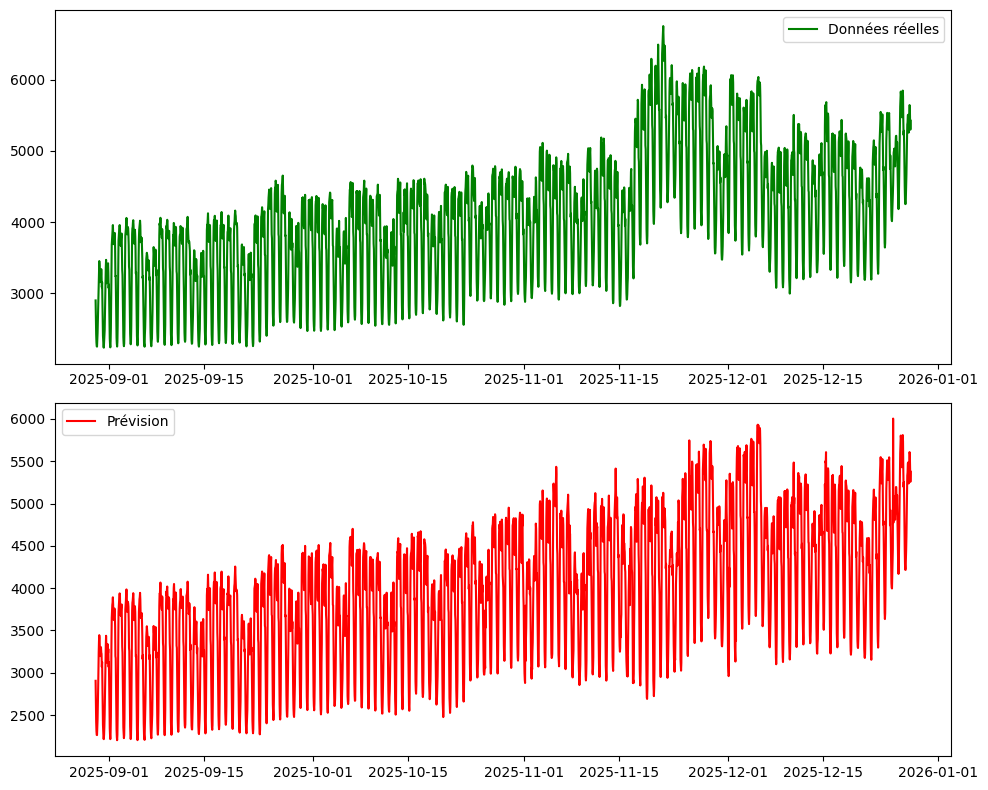

In [43]:
#subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

#données réelles
ax1.plot(test_data, label="Données réelles", color="green")
ax1.legend()

#prédictions
ax2.plot(test_pred, label='Prévision', color="red")
ax2.legend()

#afficher
plt.tight_layout()
plt.show()

**Interprétation** : On remarque tout d'abord visuellement que le motif global est plutôt bien prédit. Mais l'augmentation de la consommation très marquée fin novembre n'est pas prédite. On va voir ce qu'il en est plus rigoureusement en calculant différentes métriques.

### 5.3.2 - MAE et RMSE

Soit 1 la première prévision effectuée et $N_p$ la dernière. On note ${}_{i-1} \hat{X}_i$ la valeur prédite pour $X$ à la date $i$ effectuée à la date $i-1$. 

On peut évaluer la qualité de la prédiction par différentes métriques :
- <u>Mean Absolute Error</u> : mesure l'erreur moyenne absolue, robuste aux valeurs extrêmes
$$MAE(h) = \frac{1}{N_p} \sum_{i=1}^{N_p} |X_{i+h} - {}_{i} \hat{X}_{i+h}|$$
- <u>Root Mean Squared Error</u> : accorde plus de poids aux grosses erreurs
$$RMSE(h) = \sqrt {\frac{1}{N_p} \sum_{i=1}^{N_p} (X_{i+h} - {}_{i} \hat{X}_{i+h})^2}$$

Ces deux métriques évaluent une prévision à l'horizon h et sont à minimiser.

In [53]:
rmse = np.sqrt(mean_squared_error(test_data, test_pred))
mae = mean_absolute_error(test_data, test_pred)

print("MAE :", mae)
print("RMSE :", rmse)

MAE : 161.2902589449163
RMSE : 329.2572603960041


**Interprétation** : ces valeurs ne s'interprètent pas directement, elles sont à comparer avec celles obtenues par d'autres modèles pour déterminer quel modèle prédit le mieux. On va s'en servir pour comparer les prévisions effectuées uniquement à partir des données historiques de celles établies en ajoutant les données météorologiques.

On peut néanmoins les utiliser en les exprimant en pourcentage de la variation des données afin de comparer la précision du modèle à l’amplitude des données. On obtient alors l'erreur relative en pourcentage donnée par le formule suivante (avec MAE ou RMSE) :

$$ ER = \frac{RMSE}{max(X_t) - min(X_t)} \times 100 $$

In [58]:
variation_max = df_red['conso_final'].max() - df_red['conso_final'].min()

rmse_pct = rmse / variation_max * 100
mae_pct = mae / variation_max * 100

print("Erreur relative en % (RMSE) :", rmse_pct)
print("Erreur relative en % (MAE) :", mae_pct)

Erreur relative en % (RMSE) : 5.703399625775231
Erreur relative en % (MAE) : 2.7938724916839823


Ces résultats s'interprètent comme suit :
$$
\begin{array}{|c|l|}
\hline
\textbf{\% de la variation maximale} & \textbf{Interprétation} \\
\hline
<5\% & \text{Très bonne précision, modèle excellent} \\
\hline
5-10\% & \text{Bonne précision, erreurs relativement faibles} \\
\hline
10-20\% & \text{Acceptable pour des séries très bruyantes ou fortement variables} \\
\hline
>20\% & \text{Peut être trop élevé, le modèle peut manquer des pics importants} \\
\hline
\end{array}
$$


**Interprétation**  :
- MAE faible ($\approx$ 2.8 %) $\implies$ en moyenne la prévision se trompe peu, le modèle prédit très bien
- RMSE légèrement plus élevé ($\approx$ 5.7 %) $\implies$ les erreurs sont un peu plus grandes sur certains pics (comme on a pu le constater visuellement) mais cela reste correct.

### 5.3.3 - Statistique de Theil

La statistique de Theil est valable à l'horizon 1. Elle est définit par la formule suivante : 
$$ U = \sqrt \frac{ \sum_{i=1}^{N_p} (X_i - {}_{i-1} \hat{X}_i)^2 } { \sum_{i=1}^{N_p} (X_i - X_{i-1})^2 } $$
On a :
- U $\approx$ 0 $\implies$ bonne prévision
- U = 1 $\implies$ modèle aussi performant que le modèle naïf (on prédit $X_{t+1}$ par $X_t$)
- U > 1 $\implies$ modèle pire que le modèle naïf

In [50]:
U = np.sqrt(np.mean((test_data - test_pred)**2)) / \
    (np.sqrt(np.mean(test_data**2)) + np.sqrt(np.mean(test_pred**2)))

print("Statistique de Theil :", U)

Statistique de Theil : 0.04017272954384355


**Interprétation** : statistique très proche de 0, indique que le modèle prédit très bien

# 6 - Conclusion

Les prédictions futures à partir des données historiques sont déjà très correctes. Nous allons voir par la suite l'apport que les données météorologiques peuvent avoir sur la qualité de la prédiction.